In [1]:
# Install required libraries
!pip install kagglehub pandas scikit-learn imbalanced-learn shap xgboost matplotlib seaborn


In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import shap

# Download latest version of the dataset
path = kagglehub.dataset_download("fedesoriano/company-bankruptcy-prediction")
print("Path to dataset files:", path)

# Load dataset (CSV in downloaded path)
df = pd.read_csv(f"{path}/data.csv")  # Adjust if actual filename differs
df.head()

100%|██████████| 4.63M/4.63M [00:00<00:00, 53.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/fedesoriano/company-bankruptcy-prediction/versions/2


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [4]:
def calculate_psi(expected, actual, buckets=10):
    import numpy as np
    import pandas as pd

    psi_values = []

    # Ensure DataFrames
    expected = pd.DataFrame(expected).fillna(0)  # Fill NaNs with 0
    actual = pd.DataFrame(actual).fillna(0)

    for col in expected.columns:
        # Create bins based on expected distribution
        bins = np.linspace(expected[col].min(), expected[col].max(), buckets + 1)

        # Avoid zero range bins
        if expected[col].min() == expected[col].max():
            psi_values.append({'feature': col, 'psi': 0})
            continue

        expected_perc = np.histogram(expected[col], bins)[0] / len(expected[col])
        actual_perc   = np.histogram(actual[col], bins)[0] / len(actual[col])

        # Replace zeros to avoid divide-by-zero
        expected_perc = np.where(expected_perc == 0, 0.0001, expected_perc)
        actual_perc   = np.where(actual_perc == 0, 0.0001, actual_perc)

        psi = np.sum((expected_perc - actual_perc) * np.log(expected_perc / actual_perc))
        psi_values.append({'feature': col, 'psi': psi})

    return pd.DataFrame(psi_values)

# Usage
psi_df = calculate_psi(X_train, X_test)
psi_df.sort_values(by='psi', ascending=False).head()


,feature,psi
51,Operating profit per person,0.016088
14,Tax rate (A),0.015763
22,Per Share Net profit before tax (Yuan ¥),0.015236
58,Cash/Current Liability,0.015168
0,ROA(C) before interest and depreciation befor...,0.013641


In [5]:
# Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: Bankrupt?
0    5279
1     176
Name: count, dtype: int64
After SMOTE: Bankrupt?
0    5279
1    5279
Name: count, dtype: int64


In [6]:
# Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)
print("LR Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

LR Accuracy: 0.7587976539589443
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1320
           1       0.05      0.34      0.08        44

    accuracy                           0.76      1364
   macro avg       0.51      0.56      0.47      1364
weighted avg       0.94      0.76      0.84      1364



In [7]:
# Random Forest with RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=5, scoring='f1', cv=3, random_state=42)
rf_search.fit(X_train_res, y_train_res)
y_pred_rf = rf_search.predict(X_test)
print("RF Best Params:", rf_search.best_params_)
print(classification_report(y_test, y_pred_rf))

RF Best Params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1320
           1       0.36      0.61      0.46        44

    accuracy                           0.95      1364
   macro avg       0.68      0.79      0.72      1364
weighted avg       0.97      0.95      0.96      1364



In [8]:
# XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test)
print("XGB Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGB Accuracy: 0.968475073313783
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.51      0.52      0.52        44

    accuracy                           0.97      1364
   macro avg       0.75      0.75      0.75      1364
weighted avg       0.97      0.97      0.97      1364



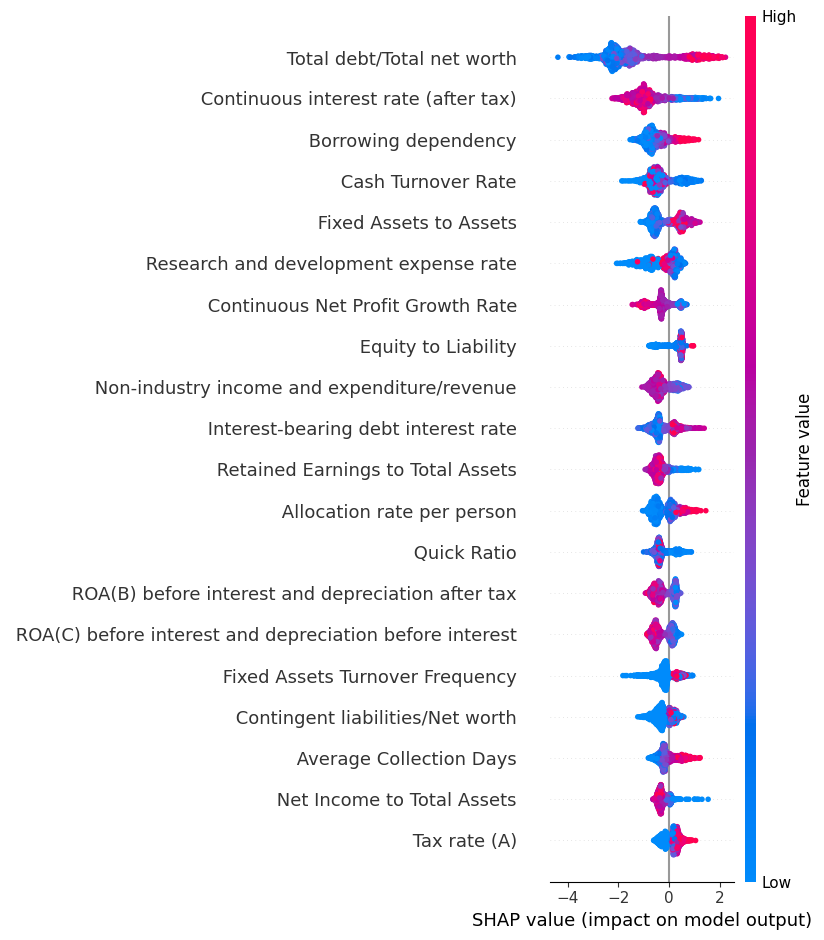

In [9]:
# SHAP explainability for XGB
explainer = shap.Explainer(xgb, X_train_res)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)